# Snippet Extraction
This notebook is used to extract snippets from the standard ECG signals processed in module 1.

Checklist:
- Extract snippets based off of non-saturated regions (done manually)
- Save these snippets in new folders with new metadata (done)
- (Maybe) Select the top 5 based off of how well they correlate with a QRS complex shape

## Initial Setup

In [3]:
# Importing packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pyarrow.feather as feather
from tqdm import tqdm

In [2]:
# Setting root directory of database to source data from
root = 'D:\Molecool\Databases\Database1'

### Functions

In [ ]:
# This is not how we took the snippets, in the end they were extracted manually
def get_snippets(filepath):
    """Get snippets from a reading passed to function. Finds windows where both ECG leads have amplitudes below a certain threshold,...
    ...and adds them to a new df - df_new
    Input: filepath of the signal feather file
    Output: Dataframe with added snippets"""
    N = 300000 #5 minute window
    df = pd.read_feather(filepath)
    
    #Cycle through different ECG leads
    for col in df.columns:
        count = 0
        pos = 0
        for j in range(pos, len(sig), N):
            if (max(sig[j:j+N]) < 8000) and (max(sig2[j:j+N]) < 8000):
                print(max(sig[j:j+N]), max(sig2[j:j+N]))
                pos = j+N
                print("Found a window ending at " + str(pos))
                df_ref.iloc[count+1,i] = j
                df_new[df_ecg.columns[(i*2)] + '/' + str(count)] = sig[j:pos].reset_index(drop=True)
                df_new[df_ecg.columns[(i*2)+1] + '/' + str(count)] = sig2[j:pos].reset_index(drop=True)
                break
        if pos == posprev:
            print("no more clean sections found")
            break
        

In [29]:
def save_snippet(snippet, path):
    """Save snippet in new file
    Inputs: snippet - a series of uV amplitudes indexed by their time, path of the patient folder where the snippet will be saved"""
    feather.write_feather(snippet, (path + '/MSNIP.ftr'))

In [20]:
def save_meta(starttime, count, lead, length, path):
    """Save Metadata of snippet in new file.
    Inputs: starttime, count, lead, and length - the metadata. Path - where the metadata will be stored"""
    d = {'Start time': starttime, 'Length': length, 'Lead': lead, 'Error Flag': False, 'Error Type': 'No error'}
    
    with open((path + '\\ManualMeta.json'), "w") as outfile:
        json.dump(d, outfile)

In [18]:
# patients = sorted(os.listdir(root))
# for pat in tqdm(patients):
#     if not pat.endswith('.json'):
#         path = root+'\\'+pat
#         folders = sorted(os.listdir(path))
#         for folder in folders:
#             ecgpath = path+'\\'+ folder
#             files = sorted(os.listdir(ecgpath))
#             for file in files: #Cycle through files in the database
#                 filepath = ecgpath + '\\'+file
#                 if file.endswith('.ftr'):
#                     get_snippets(filepath)



#             if file.endswith('.hea'):
#                 #Reading and storing the data into structure 
#                 hea_path = dpath + file #Change the location of the file or folder.
#                 f = open(hea_path, "r")
#                 pat_name = file[:5].upper()
#                 print('Reading data for subject ' + pat_name)
#                 header = open(hea_path, "r")
#                 path = root + '\\' + pat_name + '\\' + folder_name #Patient folder
#                 #os.mkdir(path)
#                 create_metadata(header, path)
#                 if not just_metadata:
#                     create_feather(hea_path, ecg_lead_names, path)

#                 f.close()

100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:24<00:00,  2.27it/s]


## Manual snippet extraction
### Visualising Each signal

In [4]:
%matplotlib inline

In [9]:
%matplotlib notebook

<IPython.core.display.Javascript object>


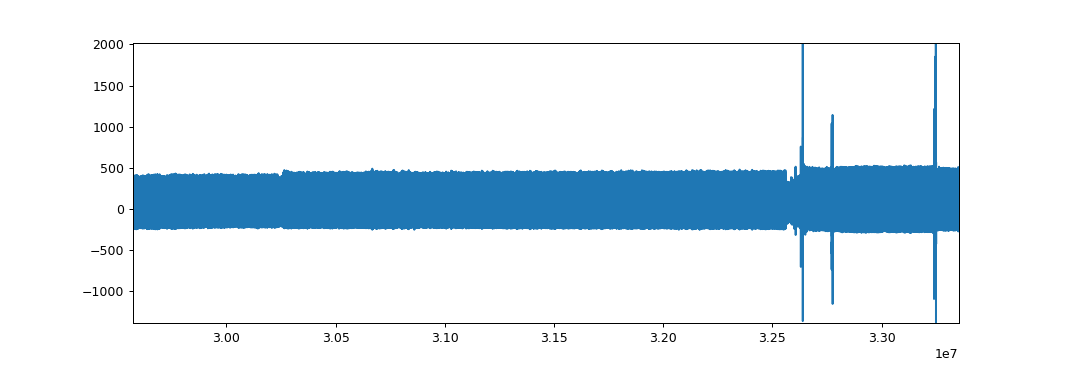

In [178]:
#look at signal
patient = 'S0441'
path = 'G:\My Drive\Molecool\Databases\Database1\\'+ patient+'\\holter'
df = pd.read_feather(path + '\\ECG.ftr')
df['ecg_0'].plot()

### Selecting and Saving snippets

In [179]:
# List of starting points (remember, a 5-minute snippet is 300,000 readings)
snippets = [0, 12500000, 18000000, 21000000, 31000000]

In [180]:
# Cycle through the snippet start time list and save snippets as new feather files in new snippet folders
N = 300000
for snip, count in zip(snippets, range(len(snippets))):
    c = str(count).zfill(3) #Pad the count with leading zeros
    filepath = path + '\\Snippet' + c
    os.mkdir(filepath)
        
    save_meta(snip, count, 'ecg_0', N, filepath)
    save_snippet(df[snip:(snip+N)], filepath)
    
    print(snip, count)

0 0
12500000 1
18000000 2
21000000 3
31000000 4


<IPython.core.display.Javascript object>


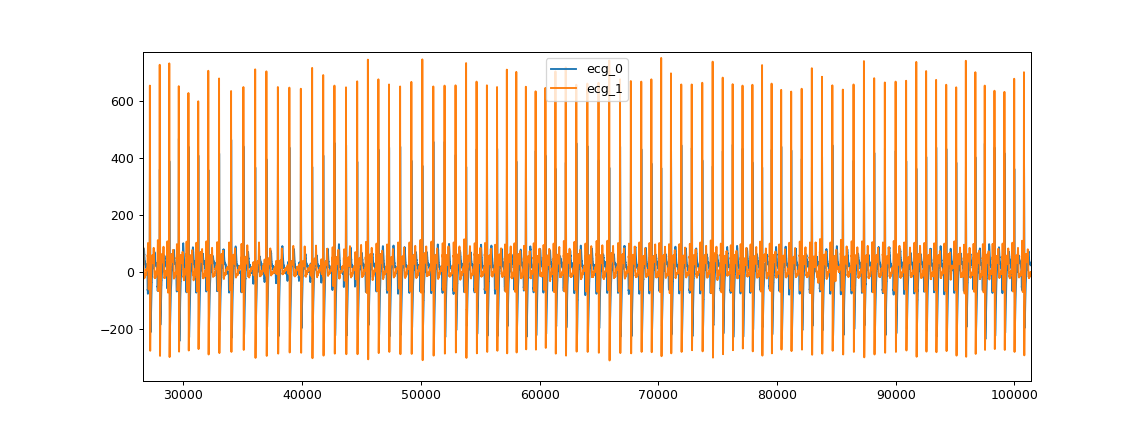

In [187]:
# Check that the feather file is ok
test = pd.read_feather(filepath + '\\MSNIP.ftr')
test.plot()